# 18a. Green band stratigraphy U1474
This notebook makes the supplementary document that shows the green%, Fe/Ti, and demarcates the depths designed as green bands for Site U1474.
## Setup
### Import modules

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
# %matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch

### File Paths

In [8]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/'
filtered_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Filtered/Green/'

### Import data 
#### XRF data (2mm)

In [9]:
ulxrf=pd.read_csv(table_path+'Supplementary Table X Site U1474 2mm-2s xrf data.csv',low_memory=False,
                  index_col='Depth CCSF (m)')
ulxrf['SectionLabel']=(ulxrf['Site']+ulxrf['Hole']+'_'+
                              ulxrf['Core'].map(str)+ulxrf['Type']+ulxrf['Section'].map(str))
ulxrf=ulxrf[ulxrf.index.duplicated()==False].copy()
ulxrf=ulxrf.sort_index()
ulxrf['Fe/Ti']=ulxrf['Fe']/ulxrf['Ti']

#### Green%

In [10]:
green=pd.read_csv(table_path+'Supplementary Table 5A - U1474 green intensity splice.csv',index_col='CCSF Depth (m)')
green['SectionLabel']=(green['Site']+green['Hole']+'_'+
                              green['Core'].map(str)+green['Type']+green['Section'].map(str))
green=green[green.index.duplicated()==False]
green=green.sort_index().iloc[:-1]
channel_cols=green.columns[7:-2]

#### Green Layers

In [13]:
green_layers=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')

#### Sand Layers

In [ ]:
sand_layers=pd.read_csv(table_path+'Supplementary Table X Site U1474 Sand Layers.csv')

### Masking

In [15]:
ulxrf['Masked']=False

#### Mask section ends

In [16]:
for i,sect in enumerate(ulxrf['SectionLabel'].unique()):
    clear_output(wait=True)
    t_ids=ulxrf[ulxrf['SectionLabel']==sect].index[:5].tolist()
    b_ids=ulxrf[ulxrf['SectionLabel']==sect].index[-5:].tolist()
    ids=t_ids+b_ids
    ends=ulxrf.loc[ids]
    final_ids=ends[ends['Fe/Ti']>=5].index.tolist()
    ulxrf.loc[final_ids,['Masked']]='Section End'

#### Mask Sand

In [18]:
for i,l in enumerate(sand_layers.index):
    clear_output(wait=True)
    base=sand_layers.loc[l,'Bottom depth CCSF (m)']
    top=sand_layers.loc[l,'Top depth CCSF (m)']
    ulxrf.loc[top:base,'Masked']='Sand'
    green.loc[top:base,'Green%']=np.nan
#     print(i,'/',len(sand_layers))  

#### Mask Pyrite

In [21]:
pyrite=pd.read_csv(data_path+'U1474/pyrite.in.xrf.scans.csv')

In [22]:
for i,l in enumerate(pyrite.index):
    clear_output(wait=True)
    base=pyrite.loc[l,'Bottom Depth CCSF (m)']
    top=pyrite.loc[l,'Top Depth CCSF (m)']
    ulxrf.loc[top-.0025:base+.0025,'Masked']='Pyrite'
#     print(i,'/',len(pyrite))   

### Chemical Records
We use XRF core scanning data from Babin et al., 2020 to 1) Show how sand layers were identified in the core, and 2) Connect sediment greening and pyritization with diagenesis using the Fe/Ti ratio. The dataset has a resolution of 2 mm.

In [29]:
chem=pd.DataFrame(index=ulxrf.index)
chem['SectionLabel']=ulxrf['SectionLabel']
chem['Si/Al']=(ulxrf['Si']/ulxrf['Al'])
chem['Fe/Ti']=(ulxrf['Fe']/ulxrf['Ti'])
chem['Masked']=ulxrf['Masked']
chem.loc[chem['Masked']==True,'Fe/Ti']=np.nan

### Import Splice info

In [23]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)
section_list['Length (m)']=section_list['Bottom Depth CCSF (m)']-section_list['Top Depth CCSF (m)']
section_list=section_list.set_index('SectionLabel')

sections=pd.read_csv(data_path+'SectionSummaries/spliceSectionsU1474.csv')['sectionLabel'].tolist()
sections=sections[:44]

## Core Photos
### Import core photo metadata

In [26]:
cpmd=pd.read_csv(data_path+'U1474/corePhotosMetadataU1474.csv')
cpmd['SectionLabel']=cpmd['Site']+cpmd['Hole']+'_'+cpmd['Core'].map(str)+cpmd['Type']+cpmd['Sect'].map(str)
cpmd['Cropped image filename (JPEG)']=cpmd['Cropped image filename'].str[:-4]+'.jpeg'
cpmd.set_index('SectionLabel',inplace=True)
cpmd=cpmd[cpmd['Display status (T/F)']=='T']

In [27]:
def path_finder(section):
    if section[5]=='A':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474A-LSIMG/'
    elif section[5]=='B':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474B-LSIMG/'
    elif section[5]=='C':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474C-LSIMG/'
    elif section[5]=='D':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474D-LSIMG/'
    elif section[5]=='E':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474E-LSIMG/'
    else:
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474F-LSIMG/'
    return path

In [28]:
# aspects=[]
# for i,sect in enumerate(sections):
#     shp=rphot[sect].size
#     aspects.append(shp[1]/shp[0])
# aspects=np.array(aspects)
# naspests=((16.6/aspects)-1)/2

## Make results PDF

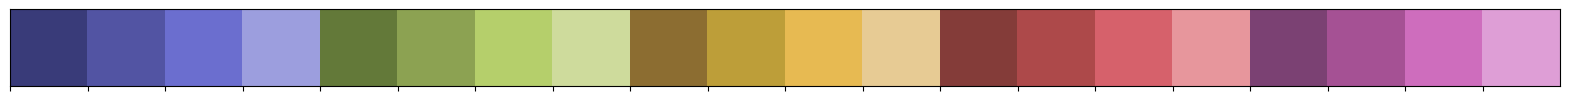

In [30]:
colors=sns.color_palette('tab20b')
sns.palplot(colors)

### Test Figures
#### Four Logs
I'm keeping this just in case I ever want to use it

In [31]:
green_colors_no_alpha=['#f0ebf2','#edf6f5','#fdfced']

In [32]:
### setup gridspec
def makeLog(number,side):
    
    sect=sections[number]
    path=path_finder(sect)
    rphot = Image.open(path+cpmd.loc[sect,'Cropped image filename'][:-4]+'-LSIMG.jpg')
    fphot = Image.open(filtered_photos+cpmd.loc[sect,'Cropped image filename'])
    aspect=rphot.size[1]/rphot.size[0]
    
    if side=='left':
        cax1=fig.add_subplot(gs[:,0])
        cax2=fig.add_subplot(gs[:,1])
        ax3=fig.add_subplot(gs[:,2:6])
        ax5=fig.add_subplot(gs[:,6:10])
    else:
        cax1=fig.add_subplot(gs[:,12])
        cax2=fig.add_subplot(gs[:,13])
        ax3=fig.add_subplot(gs[:,14:18])            
        ax5=fig.add_subplot(gs[:,18:22])        

    ### despine
    sns.despine(ax=ax3,top=False,bottom=True,left=True,right=True)
    sns.despine(ax=ax5,top=True,bottom=False,left=True,right=False)
    for ax in [ax3,ax5]:        
        ax.patch.set_alpha(0)
        ax.yaxis.set_visible(False)

    ### Title
    if side=='left':
        cax1.annotate(sect[:5]+' Hole '+sect[5]+' '+sect[7:]+'\nSplice Sect '+str(n1+1)+'/213',
                     xy=(.29,.92),xycoords='figure fraction',
                     verticalalignment='center',horizontalalignment='center',
                     size=12,fontweight='bold')
    else:
        cax1.annotate(sect[:5]+' Hole '+sect[5]+' '+sect[7:]+'\nSplice Sect '+str(n2+1)+'/213',
                     xy=(.75,.92),xycoords='figure fraction',
                     verticalalignment='center',horizontalalignment='center',
                     size=12,fontweight='bold')

    ### setup columns
    feti_data=chem.loc[chem['SectionLabel']==sect,'Fe/Ti']
    green_data=green.loc[green['SectionLabel']==sect,'Green%']

    ### Image
    sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
                  section_list.loc[sect,'Top Depth CCSF (m)'])
    extentlist=[0,sect_length/aspect,
                section_list.loc[sect,'Bottom Depth CCSF (m)'],
               section_list.loc[sect,'Top Depth CCSF (m)']]
    
    cax1.imshow(rphot,extent=extentlist)
    sns.despine(ax=cax1,top=True,bottom=True,left=False,right=True)
    cax1.xaxis.set_visible(False)
    cax1.set_ylabel('Depth CCSF (m)')
    
    cax2.imshow(fphot.rotate(270, Image.NEAREST, expand = 1),extent=extentlist)
    sns.despine(ax=cax2,top=True,bottom=True,left=False,right=True)
    cax2.xaxis.set_visible(False)
    cax2.yaxis.set_visible(False)

    ### Actual Plots
    ax3.plot(green_data.values,green_data.index,lw=.5,color='k')
    ax5.plot(feti_data.dropna(),feti_data.dropna().index,color='grey',lw=.5)

    ### coloring
    sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
    sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
    
    if aspect<17:
        l_limit=0.05
    else:
        l_limit=0
    
    #### green
    sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                                (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                                (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                                (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]
            
    for gl in sect_green.index:
        if sect_green.loc[gl,'Class']==1:
            c=green_colors_no_alpha[0]
            for ax in [ax3,ax5]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)
        elif sect_green.loc[gl,'Class']==2:
            c=green_colors_no_alpha[1]
            for ax in [ax3,ax5]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)
        elif sect_green.loc[gl,'Class']==3:
            c=green_colors_no_alpha[2]
            for ax in [ax3,ax5]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)


    ### Labels
    ax3.xaxis.tick_top()
    ax3.xaxis.set_label_position('top') 
    ax3.set_xlabel('Green Pixels [%]')
    
    ax5.set_xlabel('Fe/Ti')
    
    ax5.yaxis.tick_right()
    ax5.yaxis.set_label_position('right') 
    ax5.set_ylabel('Depth CCSF (m)')
    
    for ax in [ax3,ax5]:
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
    for ax in [cax1,ax5]:
        minor_locator = AutoMinorLocator(2)
        ax.yaxis.set_minor_locator(minor_locator)
    
    ### xlims
    ax3.set_xlim(0,100)
        
    ### ylims
    for i,a in enumerate([ax3,ax5]):
        a.set_ylim(section_list.loc[sect,'Bottom Depth CCSF (m)'],
                   section_list.loc[sect,'Top Depth CCSF (m)'])

    if side=='left':
        ax5.set_ylabel('')
    else:
        cax1.set_ylabel('')

In [33]:
legend_elements = [Patch(facecolor=green_colors_no_alpha[2], edgecolor='k', label='Class 3'),
                   Patch(facecolor=green_colors_no_alpha[1], edgecolor='k', label='Class 2'),
                   Patch(facecolor=green_colors_no_alpha[0], edgecolor='k', label='Class 1')]

In [34]:
green_colors_no_alpha=['#f0ebf2','#edf6f5','#fdfced']

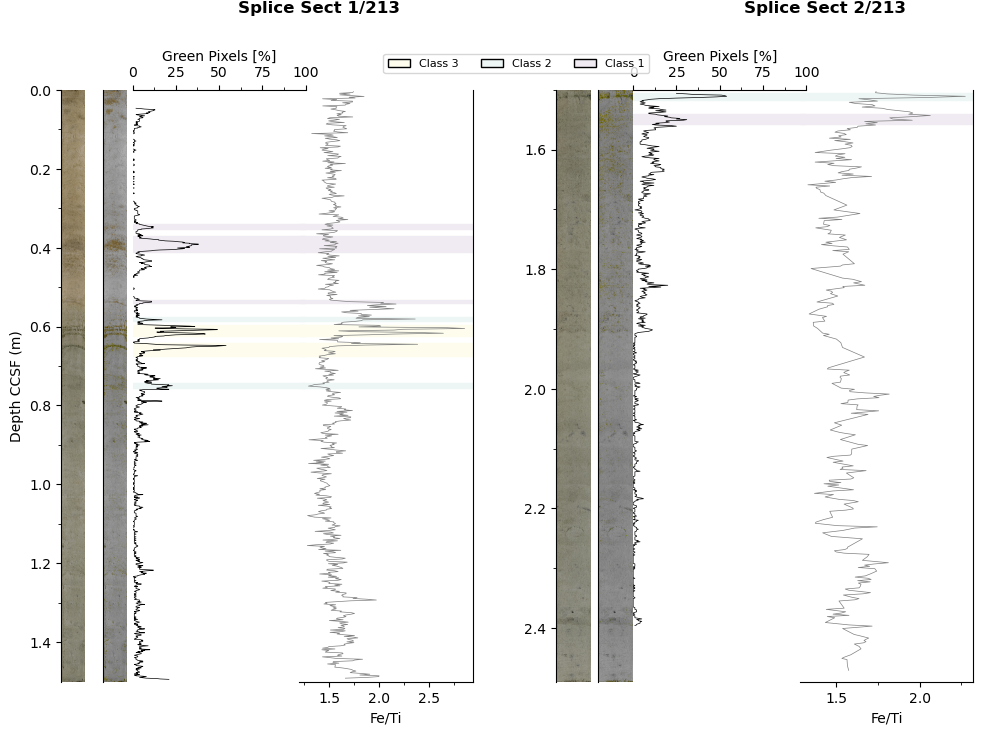

In [35]:
n1=0
n2=1
fig=plt.figure(figsize=(11,8),facecolor='w')
gs = gridspec.GridSpec(1, 22, figure=fig,wspace=-.13,left=.1,right=.94,top=.84,bottom=.1)
makeLog(n1,'left')
makeLog(n2,'right')
fig.legend(handles=legend_elements,loc=(.39,.9),ncol=3,fontsize=8)
# fig.savefig('/Users/danielbabin/Downloads/test.png',dpi=600)

## Build PDF

In [36]:
ns=iter(np.arange(0,len(sections)).tolist())
zns=zip(*[ns]*2)

### All

In [37]:
document_path='/Users/danielbabin/GitHub/Green_Bands/Documents/Green_Band_Stratigraphy_Charts/'
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(document_path+'U1474 green band stratigraphy.pdf') as pdf:
    for n1,n2 in zns:
        clear_output(wait=True)
        fig=plt.figure(figsize=(11,8))
        gs = gridspec.GridSpec(1, 22, figure=fig,wspace=-.13,left=.1,right=.94,top=.84,bottom=.1)
        makeLog(n1,'left')
        makeLog(n2,'right')
        fig.legend(handles=legend_elements,loc=(.39,.9),ncol=3,fontsize=8)
        pdf.savefig(fig,dpi=900,orientation='landscape')
        plt.close()
        print(n1,'/',len(sections))
        del fig
        del gs

42 / 44
